In [ ]:
%load_ext autoreload
%autoreload 2
from src.vnc import run_vnc_simulation


import pandas as pd
import numpy as np
from datetime import date
import matplotlib.pyplot as plt
from pathlib import Path
from hydra import initialize, compose
from hydra.core.hydra_config import HydraConfig
import jax
# jax.config.update("jax_enable_x64", True)
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1' # Use GPU 0
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = "0.95"


from src.vnc import *
from src.plot_utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
experiment='Stim_Neurons'
with initialize(version_base=None, config_path="../configs"):
    cfg=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg)

for k in cfg.paths.keys():
    if (k != 'user'):
        cfg.paths[k] = Path(cfg.paths[k])
        cfg.paths[k].mkdir(parents=True, exist_ok=True)


experiment='default'
with initialize(version_base=None, config_path="../configs"):
    cfg_old=compose(config_name='config.yaml', overrides= [f"experiment={experiment}", "paths=glados", "version=debug", f'run_id=Testing'],return_hydra_config=True,)
    HydraConfig.instance().set_config(cfg_old)

for k in cfg_old.paths.keys():
    if (k != 'user'):
        cfg_old.paths[k] = Path(cfg_old.paths[k])
        cfg_old.paths[k].mkdir(parents=True, exist_ok=True)


In [3]:
params, config = load_vnc_net(cfg)


In [4]:
params_old, config_old = vnc_old.load_vnc_net(cfg_old)

Setting sizes, normSize: 668150423.0
Setting sizes, NaN indices: (array([], dtype=int64),)


/home/eabe/Research/Github/Pugliese_2025/src/vnc_old.py:372: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stim_neurons = jnp.array(cfg.experiment.stimNeurons, dtype=jnp.int64)
/home/eabe/Research/Github/Pugliese_2025/src/sim_utils_old.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[np.isnan(sizes)] = normSize
/home/eabe/Research/Github/Pugliese_2025/src/sim_utils_old.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydat

In [6]:
start_time = time.time()

W_rw = reweight_connectivity(
    params.W, config.exc_synapse_multiplier, config.inh_synapse_multiplier
)

R0 = jnp.zeros((W_rw.shape[1],))

# Determine which run function to use based on configuration
if config.shuffle:
    run_func = run_shuffle
    print("Running simulation with shuffle")
elif config.noise:
    run_func = run_noise
    print("Running simulation with noise")
else:
    run_func = run_no_shuffle
    print("Running simulation without shuffle or noise")

vmap_axes = (
    None,  # W
    None,  # R0
    None,  # tAxis
    None,  # T
    None,  # dt
    None,  # inputs
    None,  # pulseStart
    None,  # pulseEnd
    0,  # tau
    0,  # threshold
    0,  # a
    0,  # frCap
    None,  # seed
    None,  # stdvProp or shuffle indices (depends on function)
    None,  # excDnIdxs
    None,  # inhDnIdxs
    None,  # excInIdxs
    None,  # inhInIdxs
    None,  # mnIdxs
)

# Prepare additional parameter based on simulation type
if config.noise:
    additional_param = config.noise_stdv_prop
else:
    additional_param = None

Rs = jit(vmap(run_func, in_axes=vmap_axes))(
    W_rw,
    R0,
    config.t_axis,
    config.T,
    config.dt,
    params.input_currents,
    config.pulse_start,
    config.pulse_end,
    params.tau,
    params.threshold,
    params.a,
    params.fr_cap,
    params.seeds,
    additional_param,
    params.exc_dn_idxs,
    params.inh_dn_idxs,
    params.exc_in_idxs,
    params.inh_in_idxs,
    params.mn_idxs,
)

end_time = time.time()

print(f"Time to solve system with vmap: {end_time - start_time:.3f} seconds")


Running simulation without shuffle or noise
Time to solve system with vmap: 51.654 seconds


In [ ]:

n_neurons = config.n_neurons
num_sims = config.num_sims
tau = sample_positive_truncnorm(
    float(cfg.neuron_params.tauMean),
    float(cfg.neuron_params.tauStdv),
    n_neurons,
    num_sims,
    seeds=np.arange(num_sims),
)
a = sample_positive_truncnorm(
    float(cfg.neuron_params.aMean),
    float(cfg.neuron_params.aStdv),
    n_neurons,
    num_sims,
    seeds=np.arange(num_sims),
)
threshold = sample_positive_truncnorm(
    float(cfg.neuron_params.thresholdMean),
    float(cfg.neuron_params.thresholdStdv),
    n_neurons,
    num_sims,
    seeds=np.arange(num_sims),
)
frcap = sample_positive_truncnorm(
    float(cfg.neuron_params.frcapMean),
    float(cfg.neuron_params.frcapStdv),
    n_neurons,
    num_sims,
    seeds=np.arange(num_sims),
)

In [58]:
params, config = load_vnc_net(cfg)


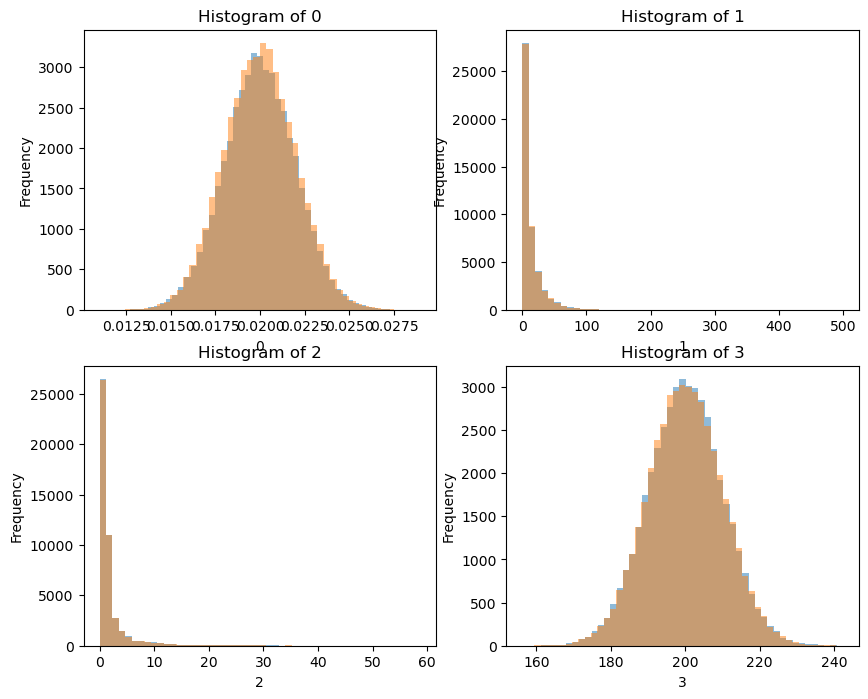

In [5]:
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()
for n, (orig,new) in enumerate(zip([params_old.tau,params_old.threshold,params_old.a,params_old.fr_cap], [params.tau, params.threshold, params.a, params.fr_cap])):
    axs[n].hist(orig.flatten(), bins=50, alpha=0.5, label='Sampled')
    axs[n].hist(new.flatten(), bins=50, alpha=0.5, label='Original')
    axs[n].set_title(f"Histogram of {n}")
    axs[n].set_xlabel(n)
    axs[n].set_ylabel("Frequency")

In [49]:
from jax.scipy.stats import truncnorm

In [29]:
truncnorm?

Type:        module
String form: <module 'jax.scipy.stats.truncnorm' from '/home/eabe/miniconda3/envs/vnc-closedloop/lib/python3.11/site-packages/jax/scipy/stats/truncnorm.py'>
File:        ~/miniconda3/envs/vnc-closedloop/lib/python3.11/site-packages/jax/scipy/stats/truncnorm.py
Docstring:   <no docstring>

In [8]:
results = Rs

In [9]:
results.shape

(10, 4561, 2000)

In [7]:
results = run_vnc_simulation(cfg)

/home/eabe/Research/Github/Pugliese_2025/src/vnc.py:372: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in array is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/jax-ml/jax#current-gotchas for more.
  stim_neurons = jnp.array(cfg.experiment.stimNeurons, dtype=jnp.int64)
/home/eabe/Research/Github/Pugliese_2025/src/sim_utils.py:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sizes[sizes.isna()] = normSize
/home/eabe/Research/Github/Pugliese_2025/src/sim_utils.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-do

Running simulation without shuffle or noise
Time to solve system with vmap: 49.853 seconds


0.07221431


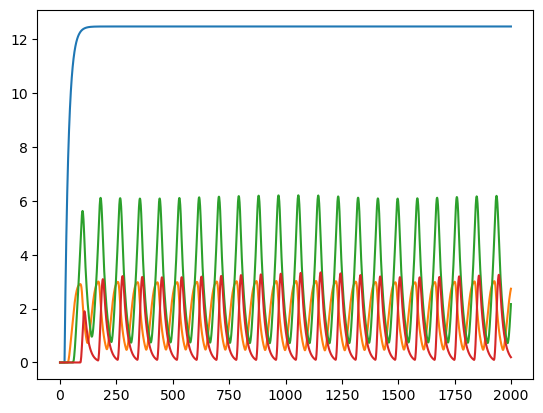

In [10]:
R = results[8]


wTable = pd.read_csv("../data/manc t1 connectome data/wTable_20231020_DNtoMN_unsorted_withModules.csv",index_col=0)
nonMns = wTable.loc[(wTable["bodyId"]==10093) | (wTable["bodyId"]==10707) | (wTable["bodyId"]==13905) | (wTable["bodyId"]==11751)]
mnIdxs = wTable.loc[wTable["class"]=="motor neuron"].index


for i in nonMns.index:
    plt.plot(R[i])
    #plt.plot(Rtsp[i])

print(np.mean(R))
